# In-Class Exercise (Lecture 9)

In [1]:
import numpy as np
import pandas as pd
np.random.seed(12345)
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(6, 3))
PREVIOUS_MAX_ROWS = pd.options.display.max_rows
pd.options.display.max_rows = 20
np.set_printoptions(precision=6, suppress=True)

---

In this exercise, you are going to explore the estimation uncertainty in the covariance term. To investigate this question, we conduct simple Monte Carlo simulations and next introduce the concept of Bootstrap. First, you need to load the dataset **"stock_px_2.csv"** used in lecture 9, as follows: 

In [2]:
close_px_all = pd.read_csv('../data/stock_px_2.csv',
                           parse_dates=True, index_col=0)
close_px = close_px_all[['AAPL', 'MSFT', 'XOM']]
close_px.head()

,AAPL,MSFT,XOM
2003-01-02,7.40,21.11,29.22
2003-01-03,7.45,21.14,29.24
2003-01-06,7.45,21.52,29.96
2003-01-07,7.43,21.93,28.95
2003-01-08,7.28,21.31,28.83


Next, we focus on the subsample of AAPL and MSFT between 2006 and 2010 and compute their daily stock returns as follows:

In [3]:
rets = close_px.loc['2006':'2010'][['AAPL', 'MSFT']].pct_change().dropna()
rets.head()

,AAPL,MSFT
2006-01-04,0.002943,0.004568
2006-01-05,-0.007870,0.000827
2006-01-06,0.025813,-0.002891
2006-01-09,-0.003277,-0.002071
2006-01-10,0.063248,0.005396


Using the above five-year daily stock return data, we estimate the covariance matrix of stock returns, denoted as $\Sigma$, and we use $\Sigma$ to simulate stock return data later. 

In [18]:
Σ = rets.cov().values    # we treat Σ as the hypothetical true covariance matrix of stock returns
print(Σ)

[[0.000651 0.000248]
 [0.000248 0.000412]]


## Q1.1

In this question, you are going to simulate the daily stock returns (of AAPL and MSFT) using an independent and identically distributed (IID) multivariate normal distribution, i.e., $\mathcal{N} (0, \Sigma)$. Next, we compute the monthly stock returns as the sum of daily stock returns per month (Hint: Resampling). 

The codes used to simulate daily stock returns are given as follows:

In [5]:
np.random.seed(1)
T_sim = rets.shape[0]
rets_sim_d = pd.DataFrame(np.random.multivariate_normal(mean=np.zeros(2), cov=Σ, size=T_sim), 
                          index=rets.index, columns=['AAPL', 'MSFT'])
rets_sim_d.head()

,AAPL,MSFT
2006-01-04,-0.033880,-0.032813
2006-01-05,0.021831,-0.006564
2006-01-06,-0.001253,-0.044251
2006-01-09,-0.035508,-0.036657
2006-01-10,-0.005556,-0.008196


#### Questions:

* What is the correlation coefficient between the daily stock returns of AAPL and MSFT in this simulation path?

* What is the correlation coefficient between the monthly stock returns of AAPL and MSFT in this simulation path?

* Are the correlation coefficients estimated at daily and monthly frequencies close to their hypothetical true values?

In [6]:
rets_sim_m = rets_sim_d.resample('ME').sum()

In [7]:
print(rets_sim_d.corr().iloc[0,1])
print(rets_sim_m.corr().iloc[0,1])
print(rets.corr().iloc[0,1])

0.5067797841479698
0.4767848184563474
0.4791622656397554


## Q1.2

Following the exercise in Q1.1, you need to repeat the simulations for 10,000 times. In each simulation, you record the correlation coefficients estimated using the daily or monthly return data. Finally, you need to report the following:
* What are the average daily and monthly correlation coefficients between AAPL and MSFT across these 10,000 simulations?
* Are the monthly correlation estimates noisier or more precise than the daily coefficient estimates? What do you learn from this simulation exercise? (Hint: You can report the quantiles across 10,000 simulations or make histograms). 

In [8]:
nsim = 10000

corr_seq = np.zeros((nsim, 2))
for i in range(nsim):
    np.random.seed(i)
    rets_sim_d = pd.DataFrame(np.random.multivariate_normal(mean=np.zeros(2), cov=Σ, size=T_sim), 
                              index=rets.index)
    rets_sim_m = rets_sim_d.resample('ME').sum()
    corr_seq[i,0] = rets_sim_d.corr().iloc[0,1]
    corr_seq[i,1] = rets_sim_m.corr().iloc[0,1]


In [9]:
corr_seq_df = pd.DataFrame(corr_seq, columns=['daily', 'monthly'])

In [10]:
corr_seq_df.mean()

daily      0.479024
monthly    0.476179
dtype: float64

In [11]:
corr_seq_df.quantile((0.05, 0.95))

,daily,monthly
0.05,0.442605,0.304165
0.95,0.513818,0.630489


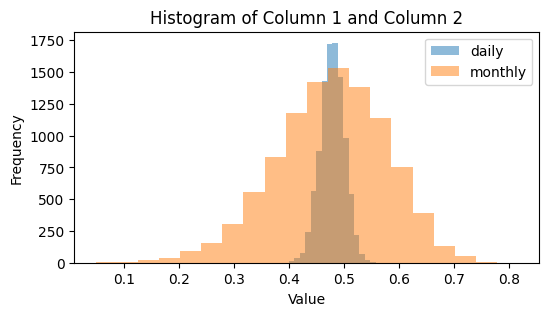

In [12]:
# Plot histograms for the desired columns in one plot
plt.hist(corr_seq_df['daily'], alpha=0.5, label='daily', bins=20)
plt.hist(corr_seq_df['monthly'], alpha=0.5, label='monthly', bins=20)

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Column 1 and Column 2')

# Add a legend
plt.legend()

# Show the plot
plt.show()

From this example, we learn that estimating the second moment (e.g., covariance, correlation, or variance) at higher frequencies seems to provide less volatile estimates than at lower frequencies. In reality, practitioners often estimate the covariance matrix of asset returns using daily data or even minute-to-minute return data. 

## Q1.3

How to quantify the estimation uncertainty in the correlation between stock returns of AAPL and MSFT? -- Bootstrapping

Suppose that $T$ is the time-series sample size of the observed dataset. In this question, **we focus on the daily frequency**, i.e., $T = 1258$ days. 

* First, we randomly draw (with replacement) a sample of $T$ days from ```rets```.
  
* Second, we compute the correlation coefficients between AAPL and MSFT for each randomly sampled dataset.
  
* Repeat the above two steps for 10,000 times, and report the mean and $90\%$ quantiles of the correlation coefficients.

In this question, you are asked to create a Python program to implement the Bootstrap procedure described above. 

In [24]:
def get_corr_bootstrap(data_df, random_seed):
    np.random.seed(random_seed)
    sample_index = np.random.choice(a=np.arange(stop=data_df.shape[0], dtype=np.int64), 
                                    size=data_df.shape[0])
    return data_df.iloc[sample_index,:].corr().iloc[0,1]
    

In [25]:
get_corr_bootstrap(rets, 2)

np.float64(0.4546871277867021)

In [27]:
num_bootstrap = 10000
corr_seq = np.zeros(num_bootstrap)

import time
t = time.time()
for i in range(num_bootstrap):
    corr_seq[i] = get_corr_bootstrap(rets, i)
print(time.time() - t)

corr_seq = pd.Series(corr_seq)
print(corr_seq.mean())
print(corr_seq.quantile((0.05,0.95)))

3.5292110443115234
0.4792042569630469
0.05    0.408174
0.95    0.546972
dtype: float64


<Axes: >

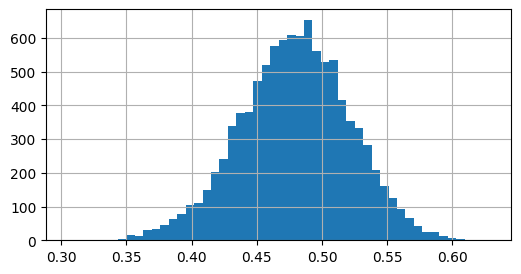

In [16]:
corr_seq.hist(bins=50)

---

# END